# Task 3: Transfer Learning

In [30]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import ResNet50V2

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import importlib
import seaborn as sns
import sys

import src.preprocessing as preprocessing
import src.models as models

importlib.reload(preprocessing)
importlib.reload(models)

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [2]:
# Set up your Image Generators for the training, validation, and test data.
img_height, img_width = 128, 128
channels = 3
batch_size = 32

path_train = "../data/train"
path_val = "../data/val"
path_test = "../data/test"

train_data_gen = preprocessing.get_image_generator(
    path_train, 
    img_height, 
    img_width, 
    batch_size, 
    shuffle=True, 
    preprocess=True)

val_data_gen = preprocessing.get_image_generator(
    path_val, 
    img_height, 
    img_width, 
    batch_size, 
    shuffle=False, 
    preprocess=False)
test_data_gen = preprocessing.get_image_generator(
    path_test, 
    img_height, 
    img_width, 
    batch_size, 
    shuffle=False, 
    preprocess=False)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [3]:
# Set up the classification
metrics=['accuracy']

# Base Model

In [34]:
# Base model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False  # freeze all layers

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))  
model.add(Dropout(0.2)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,837,441 (90.93 MB)

 Trainable params: 272,641 (1.04 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

# Train the Model


In [7]:
#The Best Hyperparameters
results_csv = "../results/hyperparameter_tuning_results.csv"
df_results = pd.read_csv(results_csv)

# Select the best configuration based on highest validation accuracy.
best_config = df_results.sort_values('best_val_accuracy', ascending=False).iloc[0]
best_dropout = best_config['dropout_rate']
best_filters = int(best_config['first_filters'])
best_lr = best_config['learning_rate']
best_dense_units = int(best_config['dense_units'])

print("Best Hyperparameters:")
print(best_config)


Best Hyperparameters:
dropout_rate           0.200000
first_filters         16.000000
learning_rate          0.000500
dense_units          512.000000
best_val_accuracy      0.877604
best_epoch             4.000000
final_val_loss         0.319125
Name: 10, dtype: float64


In [8]:
total_train = train_data_gen.samples
total_val = val_data_gen.samples

print(f"total_train: {total_train}")
print(f"total_val: {total_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train // batch_size}")

total_train: 1600
total_val: 400
batch_size: 32
steps_per_epoch: 50


In [35]:
#Train

epochs = 30

history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 663ms/step - accuracy: 0.7327 - loss: 0.5656 - val_accuracy: 0.7891 - val_loss: 0.4394
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 679ms/step - accuracy: 0.8864 - loss: 0.2724 - val_accuracy: 0.8125 - val_loss: 0.3842
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 576ms/step - accuracy: 0.9180 - loss: 0.2470 - val_accuracy: 0.8359 - val_loss: 0.3590
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 636ms/step - accuracy: 0.9064 - loss: 0.2325 - val_accuracy: 0.8359 - val_loss: 0.3743
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 648ms/step - accuracy: 0.9438 - loss: 0.1665 - val_accuracy: 0.8255 - val_loss: 0.3698
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 555ms/step - accuracy: 0.9322 - loss: 0.1556 - val_accuracy: 0.8333 - val_loss: 0.3506
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 585ms/step - accuracy: 0.9459 - loss: 0.1367 - val_accuracy: 0.8333 - val_loss: 0.4126
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 611ms/step - accuracy: 0.9439 - loss: 0.1469 - val_accu

KeyboardInterrupt: 

### Model evaluation

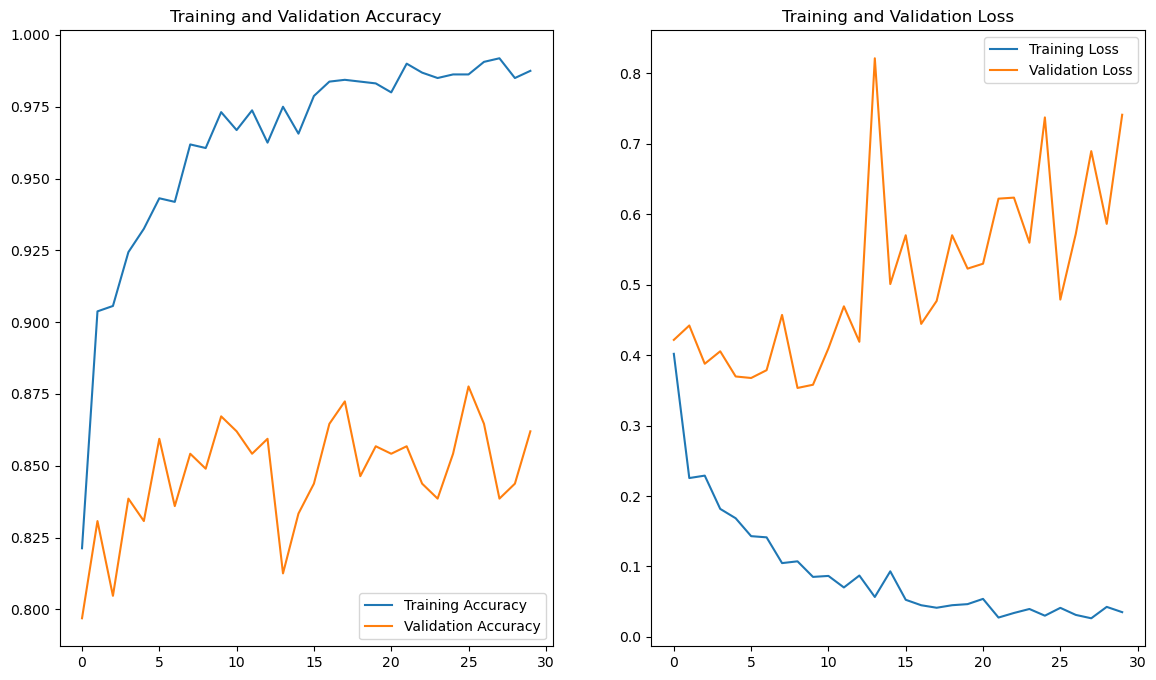

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Hyperparameter tuning

In [ ]:
# Hyperparameter options.
batch_size = [32, 64]
learning_rates = [0.001, 0.0005] 
dropout_rates = [0.1, 0.2]

# Define EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

epochs = 5

# Create hyperparameter grid and convert it to a list for progress calculation.
hyperparameter_grid = list(product(batch_size, learning_rates, dropout_rates))
total_iterations = len(hyperparameter_grid)
results = []  # List to store results from each run.

print(f"Total iterations: {total_iterations}")

for idx, (batch_size, learning_rates, dropout_rates) in enumerate(hyperparameter_grid):
    print(f"\nRunning: batch_size={batch_size}, learning_rate={learning_rates}, dropout_rate={dropout_rates}")
    
    # Build the model with the current hyperparameters.
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    base_model.trainable = False  # freeze all layers
    model = Sequential()
    model.add(base_model)   
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # Set up the optimizer and compile the model.
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rates)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=metrics)

    

    
    
    
    
    
    
    # Train the model.
    history = model.fit(
        train_data_gen,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size,
        callbacks=[early_stop],
        verbose=0  # Reduce training output during tuning.
    )
    
    # Find the best validation accuracy and the corresponding epoch.
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    final_val_loss = history.history['val_loss'][best_epoch - 1]
    
    # Append hyperparameters and performance metrics to the results.
    results.append({
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rates,
        'best_val_accuracy': best_val_acc,
        'best_epoch': best_epoch,
        'final_val_loss': final_val_loss 
    })
    print(f"Completed: best_val_accuracy={best_val_acc:.4f} at epoch {best_epoch}")

    print(idx + 1, "/", total_iterations, end="\r")  # Print progress.

# Move to a new line after the progress bar.
print("\nHyperparameter tuning complete.")



# Create a DataFrame from the results and save to CSV.
df_results = pd.DataFrame(results)
csv_filename = "../results/hyperparameter_tuning_results_transfer_learning.csv"
df_results.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

Total iterations: 8

Running: batch_size=32, learning_rate=0.001, dropout_rate=0.1
Completed: best_val_accuracy=0.8802 at epoch 5
1 / 8
Running: batch_size=32, learning_rate=0.001, dropout_rate=0.2
Completed: best_val_accuracy=0.8828 at epoch 4
2 / 8
Running: batch_size=32, learning_rate=0.0005, dropout_rate=0.1
Completed: best_val_accuracy=0.8880 at epoch 3
3 / 8
Running: batch_size=32, learning_rate=0.0005, dropout_rate=0.2


KeyboardInterrupt: 

# Train pre-trained model

In [ ]:
#Retrain your model using the complete training dataset (including the validation dataset)

In [ ]:
# Plot the training curve

In [ ]:
# Save and reload your model

# Fine-tuning the entire model

In [ ]:
#unfreeze the base model

# Retrain the model

In [ ]:
#Save the model in a different file and reload it

In [ ]:
#Test the modal on the testdata

In [ ]:
#confussion matrix

In [ ]:
#samples from the testdata with and without pre-processing